In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Building Dataset

In [ ]:
X = np.expand_dims(np.linspace(-10, 10, num=200, dtype=np.float32), -1)
#y = np.cos(X)+np.sqrt(X)
y = np.cos(X)+5

In [ ]:
plt.plot(X,y)

In [ ]:
class Regressor(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Regressor, self).__init__()
        self.hidden = torch.nn.Linear(n_input,n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
    def forward(self,x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [ ]:
model = Regressor(200,300,200)
model

In [ ]:
## Regressor parameters
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(),learning_rate)
loss_function = torch.nn.MSELoss()

In [ ]:
X_inp = torch.from_numpy(X)
print(X_inp.requires_grad)
print(X_inp.shape)
X_inp[0:10]

In [ ]:
X_inp.view(1,-1).shape

In [ ]:
y_inp = torch.from_numpy(y)
y_inp.requires_grad

In [ ]:
## Training
for t in range(200):
    pred = model(Variable(X_inp.view(1,-1)))
    loss = loss_function(pred, y_inp.view(1,-1))
        
    optimizer.step()
    optimizer.zero_grad()
    loss.backward()

    if t %50 ==0:
        plt.cla()
        plt.scatter(X_inp.data.numpy(), y_inp.data.numpy())
        plt.plot(X_inp.data.numpy(), pred.view(-1,1).data.numpy(), 'r-', lw=2)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        #plt.pause(0.1)
plt.ioff()
plt.show()

## Adding Gaussian Noise

In [ ]:
X = np.expand_dims(np.linspace(-10, 10, num=100, dtype=np.float32), -1)
x = torch.from_numpy(X)
noise = x.new_tensor(np.ones(x.size())).normal_(mean = 20, std = 150)
y = x**3 + noise

In [ ]:
plt.plot(x.data.numpy(), y.data.numpy())

In [ ]:
x.size()[0], y.size()[0]

In [ ]:
model_2 = Regressor(x.size()[0], 400, y.size()[0])
model_2

In [ ]:
learning_rate = 0.0001
optimizer = optim.SGD(model_2.parameters(),learning_rate)
loss_function = torch.nn.MSELoss()
#loss_function = torch.nn.NLLLoss()

In [ ]:
y.view(1,-1).size()

In [ ]:
model_2.forward(Variable(x.view(1,-1)))

In [ ]:
num_iter = 300
    
for i in range(num_iter):
    #model_2.zero_grad()
    preds = model_2(Variable(x.view(1,-1)))
    loss = loss_function(preds, y.view(1,-1))
    
    optimizer.step()
    optimizer.zero_grad()
    loss.backward()

    if i %50 ==0:
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), preds.view(-1,1).data.numpy(), 'r-', lw=2)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
plt.ioff()
plt.show()

## Uncertainty in Deep Ensembles

- What’s a “good” uncertainty estimate?  
    – Calibration  
    – Higher uncertainty on out-of-distribution examples  

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


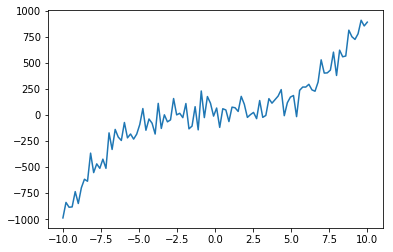

In [2]:
X = np.expand_dims(np.linspace(-10, 10, num=100, dtype=np.float32), -1)
x = torch.from_numpy(X)
noise = x.new_tensor(np.ones(x.size())).normal_(mean = 20, std = 100)
y = x**3 + noise
plt.plot(x.data.numpy(), y.data.numpy())

In [3]:
class GaussianRegressor(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, sizes, min_var = 1e-6):
        super(GaussianRegressor, self).__init__()
        self.h = torch.zeros(n_input,sizes)
        self.hidden = torch.nn.Linear(n_input,n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        self.sizes = sizes
        self.layers = [self.hidden for i in range(sizes)]
        self.num_layers = sizes
    def forward(self,x):
        h = x
        output = []
        for i in range(self.num_layers):
            out = F.relu(self.hidden(x))
            out = self.predict(out)
            output.append(out)
        mean, raw_var  = output
        var = F.softplus(raw_var) + 1e-6
        return mean, var

In [4]:
modelito = GaussianRegressor(x.size()[0], 200, y.size()[0], sizes = 2)
modelito 

GaussianRegressor(
  (hidden): Linear(in_features=100, out_features=200, bias=True)
  (predict): Linear(in_features=200, out_features=100, bias=True)
)

In [5]:
learning_rate = 0.00001
optimizer = optim.SGD(modelito.parameters(),learning_rate)
loss_function = torch.nn.MSELoss()
#loss_function = torch.nn.NLLLoss(weight=None)

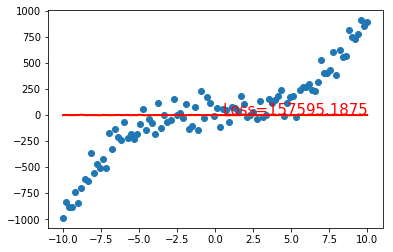

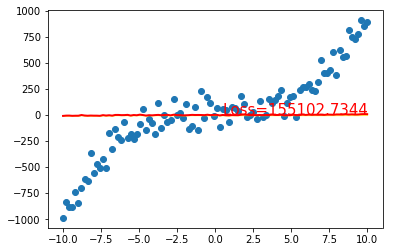

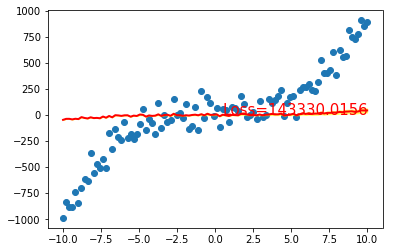

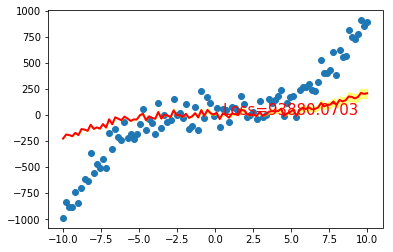

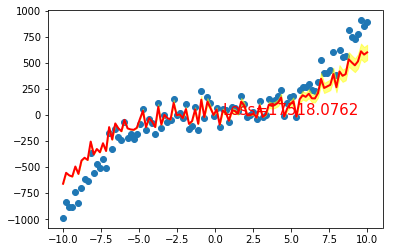

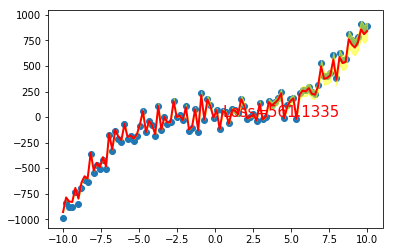

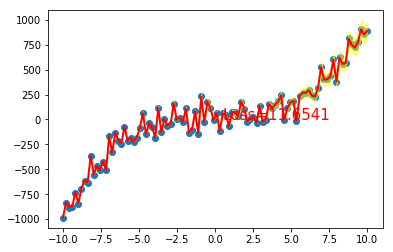

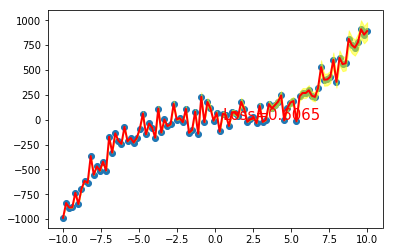

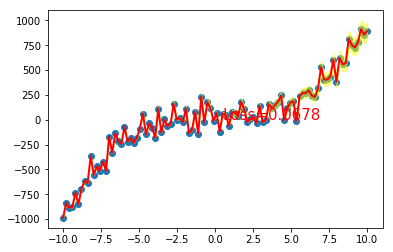

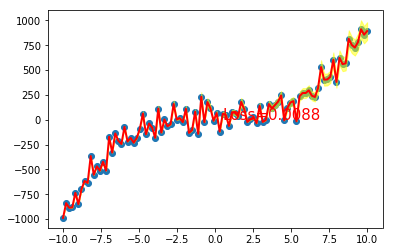

In [7]:
num_iter = 200
for i in range(num_iter):
    preds, var = modelito(Variable(x.view(1,-1)))
    loss = loss_function(preds, y.view(1,-1))
    optimizer.step()
    optimizer.zero_grad()
    loss.backward()

    if i %20 ==0:
        std = np.sqrt(var.data.numpy())
        upper = preds.data.numpy() + 3 * std
        lower = preds.data.numpy() - 3 * std
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), preds.view(-1,1).data.numpy(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower.squeeze(), upper.squeeze(), color='yellow', alpha=0.5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 15, 'color':  'red'})
        plt.pause(0.1)
plt.ioff()
plt.show()

## Ensemble training

In [8]:
def mean_var_ensemble(ensemble, x):
    en_mean = 0
    en_var = 0
    for i,model in enumerate(ensemble):
        #print(" -- model {}".format(i))
        mean,var = model(Variable(x.view(1,-1)))
        en_mean += mean
        en_var += var + mean ** 2
    en_mean /= len(ensemble)
    en_var /= len(ensemble)
    en_var -= en_mean ** 2
    return en_mean.data.numpy(), en_var.data.numpy()

In [10]:
K = 5  # ensemble size
max_iter = 1000
eps = 1e-2
learning_rate = 0.00001

In [11]:
input_size = x.size()[0]
hidden_size = 200
output_size = y.size()[0]

In [12]:
ensemble = [GaussianRegressor(input_size, 
                              hidden_size,
                              output_size,2) for i in range(K)]
optimizer = [optim.SGD(ensemble[i].parameters(),learning_rate) for i in range(K)]
losses =[torch.nn.MSELoss() for i in range(K)]

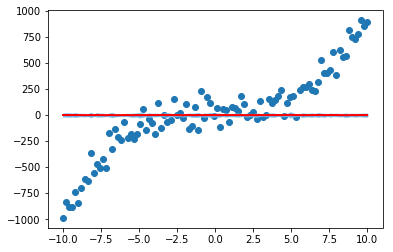

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


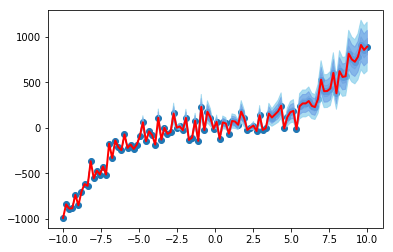

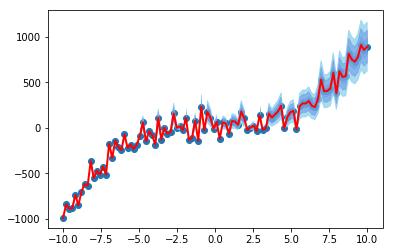

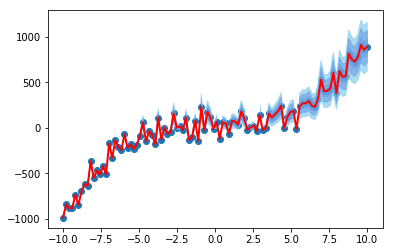

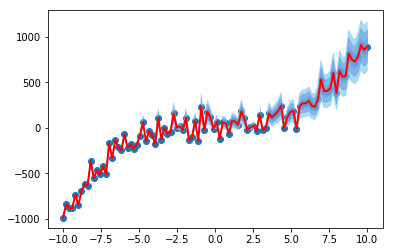

In [13]:
for i in range(max_iter):
    for model, opt, loss in zip(ensemble, optimizer, losses):
        preds, var = model(Variable(x.view(1,-1)))
        lo = loss(preds, y.view(1,-1))
        opt.step()
        opt.zero_grad()
        lo.backward()  
    if i %200 ==0:
        mean_en, var_en = mean_var_ensemble(ensemble, x)
        std = np.sqrt(var_en)
        upper_3 = mean_en + 3 * std
        lower_3 = mean_en - 3 * std
        upper_6 = mean_en + 6 * std
        lower_6 = mean_en - 6 * std
        upper_9 = mean_en + 9 * std
        lower_9 = mean_en - 9 * std
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy().squeeze(), mean_en.squeeze(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_3.squeeze(), upper_3.squeeze(), color='darkblue', alpha=0.3)
        plt.fill_between(x.data.numpy().squeeze(), lower_6.squeeze(), upper_6.squeeze(), color='mediumblue', alpha=0.5)
        plt.fill_between(x.data.numpy().squeeze(), lower_9.squeeze(), upper_9.squeeze(), color='skyblue', alpha=0.7)

        plt.pause(0.1)
plt.ioff()
plt.show()